<a href="https://colab.research.google.com/github/damiMela/BashScripts/blob/main/Market_Prediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Market Prediction

# imports and system initialization

In [ ]:
import importlib
def install_module(module_name):
    try:
        # Attempt to import the module
        importlib.import_module(module_name)
        print(f"{module_name} is already installed.")
    except ImportError:
        # Module is not installed, so install it
        import subprocess
        print(f"Installing {module_name}...")
        subprocess.check_call(['pip', 'install', module_name])
        print(f"{module_name} has been successfully installed")

In [ ]:
install_module("yfinance")

yfinance is already installed.


/usr/local/lib/python3.10/dist-packages/yfinance/base.py:48: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  _empty_series = pd.Series()


In [ ]:
import tensorflow as tf
import numpy as np
import pandas as pd
import keras


# Dataset

## download and import

In [ ]:
def download_and_save_data(symbol, start_date, end_date, interval, file_path):
    data = yf.download(symbol, start=start_date, end=end_date, interval=interval)
    data.to_csv(file_path)
    print("Data downloaded and saved successfully.")

In [ ]:
import pandas as pd
# Load data from a CSV file
def load_data(file_path):
    return pd.read_csv(file_path)

In [ ]:
import yfinance as yf


symbol = "PFE"
start_date = "2023-12-20"
end_date = "2024-02-15"
file_path = "pfizer_stock_data.csv"
interval = '5m'

try:
    df = load_data(file_path)
    print("Data loaded from file.")
except FileNotFoundError:
    # If the file doesn't exist, download the data
    download_and_save_data(symbol, start_date, end_date, interval, file_path)
    df = load_data(file_path)
    print("Data downloaded and saved.")

[*********************100%%**********************]  1 of 1 completed

Data downloaded and saved successfully.
Data downloaded and saved.


## Preparation
Cleanup, feature extraction and normalization

In [ ]:
# Clean the data
df = df.dropna()

#sort by date
df['Datetime'] = pd.to_datetime(df['Datetime'])
df = df.sort_values(by='Datetime',  ascending=[False])

#convert to Unix timestamp
df['Datetime'] = df['Datetime'].apply(lambda x: x.timestamp())

# Perform feature engineering
#df['MA_50'] = df['Close'].rolling(window=50).mean()
#df['MA_200'] = df['Close'].rolling(window=200).mean()


df = df.drop('Adj Close', axis=1)

print(df.head())


          Datetime       Open       High    Low      Close   Volume
2963  1.707944e+09  27.105000  27.129999  27.09  27.106001  1217716
2962  1.707944e+09  27.129999  27.129999  27.10  27.105000   587591
2961  1.707944e+09  27.105000  27.129999  27.10  27.125000   318054
2960  1.707943e+09  27.090000  27.105000  27.08  27.105000   246965
2959  1.707943e+09  27.083799  27.100000  27.07  27.084999   179755


In [ ]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()
scaler.fit(df)
normalized_df =  pd.DataFrame(scaler.transform(df), columns=df.columns)


In [ ]:
# # Split the data into train and test sets
train_size = int(len(normalized_df) * 0.75)
val_size = int(len(normalized_df) * 0.2)
train_data = normalized_df[:train_size]
val_data = normalized_df[train_size:train_size+val_size]
test_data = normalized_df[train_size+val_size:]

## Dataset generation

In [ ]:
def create_dataset(dataset, time_step = 1):
    dataX,dataY = [],[]

    low_column_index = dataset.columns.get_loc('Low')
    high_column_index = dataset.columns.get_loc('High')
    close_column_index = dataset.columns.get_loc('Close')
    volume_column_index = dataset.columns.get_loc('Volume')


    for i in range(len(dataset)-time_step-1):
      input = dataset.iloc[i:(i+time_step-1), [close_column_index]].values
      dataX.append(input)

      target = dataset.iloc[i+time_step, [close_column_index, high_column_index]].values
      dataY.append(target)
    return np.array(dataX),np.array(dataY)

In [ ]:
time_step = 12
X_train,Y_train =  create_dataset(train_data,time_step)
X_val,Y_val =  create_dataset(val_data,time_step)
X_test,Y_test = create_dataset(test_data,time_step)


print(f"Training on {X_train.shape[0]} elements")
print(f"Validating on {X_val.shape[0]} elements")
print(f"Testing on {X_test.shape[0]} elements")

col_count = len(X_train[0][0])
print(f"training features: {col_count}")

Training on 2210 elements
Validating on 579 elements
Testing on 136 elements
training features: 1


# Neural network

## Model Creation

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, Dropout

model = Sequential()
model.add(LSTM(50,return_sequences = True,input_shape = (X_train.shape[1],col_count)))
model.add(Dropout(0.1))
model.add(LSTM(50,return_sequences = True))
model.add(LSTM(50))
model.add(Dense(2))

In [ ]:
base_learning_rate = 0.0001
model.compile(loss = 'mean_squared_error',optimizer = 'adam', metrics=['mean_squared_error'])
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 11, 50)            10400     
                                                                 
 dropout (Dropout)           (None, 11, 50)            0         
                                                                 
 lstm_1 (LSTM)               (None, 11, 50)            20200     
                                                                 
 lstm_2 (LSTM)               (None, 50)                20200     
                                                                 
 dense (Dense)               (None, 2)                 102       
                                                                 
Total params: 50902 (198.84 KB)
Trainable params: 50902 (198.84 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


## Training

In [ ]:
loss0, accuracy0 =  model.evaluate(X_val, Y_val, verbose=1)
print("initial loss: {:.2f}".format(loss0))
print("initial mean squared error: {:.2f}".format(accuracy0))

19/19 [==============================] - 2s 7ms/step - loss: 0.4358 - mean_squared_error: 0.4358
initial loss: 0.44
initial mean squared error: 0.44


In [ ]:
history = model.fit(X_train,Y_train,
                    validation_data = (X_val,Y_val),
                    epochs = 100,
                    batch_size = 64,
                    verbose = 1)

Epoch 1/100
35/35 [==============================] - 8s 54ms/step - loss: 0.0384 - mean_squared_error: 0.0384 - val_loss: 0.0033 - val_mean_squared_error: 0.0033
Epoch 2/100
35/35 [==============================] - 1s 32ms/step - loss: 0.0022 - mean_squared_error: 0.0022 - val_loss: 0.0021 - val_mean_squared_error: 0.0021
Epoch 3/100
35/35 [==============================] - 1s 27ms/step - loss: 0.0012 - mean_squared_error: 0.0012 - val_loss: 0.0019 - val_mean_squared_error: 0.0019
Epoch 4/100
35/35 [==============================] - 1s 27ms/step - loss: 0.0012 - mean_squared_error: 0.0012 - val_loss: 0.0018 - val_mean_squared_error: 0.0018
Epoch 5/100
35/35 [==============================] - 1s 27ms/step - loss: 0.0012 - mean_squared_error: 0.0012 - val_loss: 0.0020 - val_mean_squared_error: 0.0020
Epoch 6/100
35/35 [==============================] - 1s 28ms/step - loss: 0.0012 - mean_squared_error: 0.0012 - val_loss: 0.0018 - val_mean_squared_error: 0.0018
Epoch 7/100
35/35 [=========

### Train evaluation

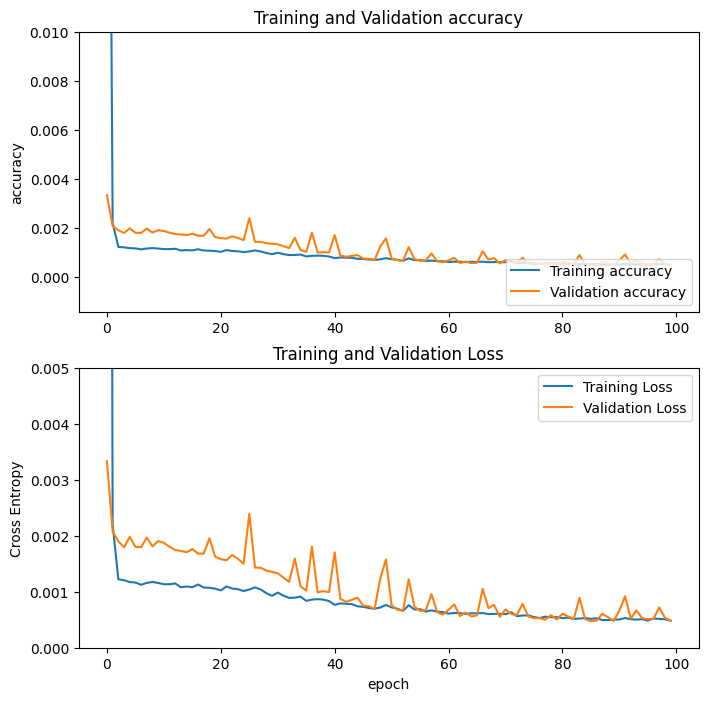

In [ ]:
import matplotlib.pyplot as plt

acc = history.history['mean_squared_error']
val_acc = history.history['val_mean_squared_error']

loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training accuracy')
plt.plot(val_acc, label='Validation accuracy')
plt.legend(loc='lower right')
plt.ylabel('accuracy')
plt.ylim([min(plt.ylim()),0.01])
plt.title('Training and Validation accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0,.005])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

## Fine tunng

In [ ]:
# freeze first layers
model.trainable = False
for layer in model.layers[-120:]:
    layer.trainable = True

model.compile(loss = 'mean_squared_error',optimizer = 'adam', metrics=['mean_squared_error'])

# Train the model
history = model.fit(X_train,Y_train,validation_data = (X_val,Y_val),epochs = 100,batch_size = 64,verbose = 1)

## Model Evaluation

In [ ]:
# Evaluate the model
loss, accuracy = model.evaluate(X_test, Y_test)
print(f'Test Loss: {loss:.4f}')
print(f'Test Accuracy: {accuracy:.4f}')

5/5 [==============================] - 0s 7ms/step - loss: 4.7507e-04 - mean_squared_error: 4.7507e-04
Test Loss: 0.0005
Test Accuracy: 0.0005


In [ ]:
# Make predictions
predictions = model.predict(X_test)

output = pd.DataFrame(columns=df.columns)
output['Close'] = predictions[:,0]
output['High'] = predictions[:,1]
output = pd.DataFrame(scaler.inverse_transform(output), columns=df.columns)


original = pd.DataFrame(scaler.inverse_transform(test_data), columns=df.columns)

# Plot the predictions
plt.subplot(2, 1, 1)
plt.plot(output['Close'], label='Predicted')
plt.plot(original['Close'], label='Actual')
plt.xlabel('Time')
plt.ylabel('Stock Price')
plt.legend()

plt.subplot(2, 1, 2)
plt.plot(output['High'], label='Predicted')
plt.plot(original['High'], label='Actual')
plt.xlabel('Time')
plt.ylabel('Stock Price')
plt.legend()
plt.show()

